# OpenBeer - DataLoader - Notebook  
  
### 0. Load modules

In [1]:
#Load modules and set seaborn styles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import glob
sns.set()

### I. Read Data

In [2]:
#set columns from header row of csv file and path
columns_to_load = { "beers":["id","brewery_id","name","cat_id","style_id","abv","ibu","srm","descript"],
                    "breweries":["id","name","address1","address2","city","state","code","country"], 
                    "categories":["id","cat_name"], 
                    "styles":["id","cat_id","style_name"],
                    "breweries_geocode":["id","brewery_id","latitude","longitude","accuracy"]}

dfs = {}
paths = [name for name in glob.glob("data\*.csv")]
files = [os.path.splitext(os.path.basename(name))[0] for name in glob.glob("data\*.csv")]
#read raw data for beers
for i,p in enumerate(paths):
    df_temp = pd.read_csv(p, usecols=columns_to_load[files[i]], na_values=[-1])
    dfs[files[i]] = df_temp.copy()

#explore top 5 rows if loaded correctly for each df
for f in files:
    print(f,dfs[f].info())

#assign each df to a separate variable for further exploration
df_beers_raw = dfs["beers"]
df_breweries_raw = dfs["breweries"]
df_breweries_geocode_raw = dfs["breweries_geocode"]
df_categories_raw = dfs["categories"]
df_styles_raw = dfs["styles"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5861 entries, 0 to 5860
Data columns (total 9 columns):
id            5845 non-null object
brewery_id    5837 non-null object
name          5837 non-null object
cat_id        4372 non-null object
style_id      4369 non-null object
abv           5825 non-null object
ibu           5822 non-null object
srm           5822 non-null object
descript      1972 non-null object
dtypes: object(9)
memory usage: 412.2+ KB
beers None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1414 entries, 0 to 1413
Data columns (total 8 columns):
id          1414 non-null int64
name        1414 non-null object
address1    1145 non-null object
address2    4 non-null object
city        1392 non-null object
state       1232 non-null object
code        779 non-null object
country     1413 non-null object
dtypes: int64(1), object(7)
memory usage: 88.5+ KB
breweries None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1304 entries, 0 to 1303
Data columns (total 5

## Beers Cleaning and enhancement

In [3]:
#making a copy of beer from raw
df_beers = df_beers_raw.copy()

### Overview:

In [4]:
#Exploring Info, NaNs and Summary statistics

for c in df_beers.columns:
    print(df_beers[c].head())

print(df_beers.info(), "\n", df_beers.describe(), "\n", df_beers.isna().sum())

0    1
1    2
2    3
3    4
4    5
Name: id, dtype: object
0     812
1     264
2     779
3     287
4    1056
Name: brewery_id, dtype: object
0               Hocus Pocus
1         Grimbergen Blonde
2    Widdershins Barleywine
3                   Lucifer
4                    Bitter
Name: name, dtype: object
0     11
1    NaN
2    NaN
3    NaN
4    NaN
Name: cat_id, dtype: object
0    116
1    NaN
2    NaN
3    NaN
4    NaN
Name: style_id, dtype: object
0    4.5
1    6.7
2    9.1
3    8.5
4      4
Name: abv, dtype: object
0    0
1    0
2    0
3    0
4    0
Name: ibu, dtype: object
0    0
1    0
2    0
3    0
4    0
Name: srm, dtype: object
0    Our take on a classic summer ale.  A toast to ...
1                                                  NaN
2                                                  NaN
3                                                  NaN
4                                                  NaN
Name: descript, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 

### Results:
Things to do:  
1. Change data types: ID will be replaced and still stored as objects, abv -> float, others->integers  
2. get rid of NaNs:all columns with NaNs exepted descript, cat, style will be dropped, cat + style NaNs will be extraced to be filled afterwards, descript will be stored separately  
3. exclude descript: second


In [5]:
print((df_beers.reset_index()[["id"]].applymap(lambda x: len(str(x))>4)))
list(df_beers[(df_beers.reset_index()[["id"]].applymap(lambda x: len(str(x))>4).values)].index)


id
0     False
1     False
2     False
3     False
4     False
...     ...
5856  False
5857  False
5858  False
5859  False
5860  False

[5861 rows x 1 columns]


[2637,
 3902,
 3904,
 3905,
 3906,
 3908,
 3909,
 3910,
 3912,
 4196,
 4198,
 4229,
 4231,
 4313,
 4314,
 4315,
 4403,
 4407,
 4410,
 4412,
 4416,
 4761,
 5616]

In [6]:


#drop beers without name or measurements
df_beers.dropna(subset=["name", "abv", "ibu", "srm"], axis = 0, inplace = True)

#drop nonsense rows
df_beers = df_beers.drop(list(df_beers[(df_beers.reset_index()[["id"]].applymap(lambda x: len(str(x))>4).values)].index), axis=0)

#extract NaN-rows in cat and style and save in csv
df_beers_cat_style_nan = df_beers[df_beers["cat_id"].isna() | df_beers[ "style_id"].isna()]
df_beers_cat_style_nan.to_csv("data\\temp\cat_style_nan.csv")

#extract and drop descript and save in csv
df_beers_descript = df_beers["descript"]
df_beers_descript.to_csv("data\\temp\\beers_descript.csv")
df_beers = df_beers.drop("descript", axis = 1)


#drop all others beers with NaNs
df_beers.dropna(axis=0, inplace=True)



[]

### Explore again

In [7]:

#get number of NaNs per column
print(df_beers.isna().sum())

#explore again
print(df_beers.info())
[print(df_beers[c].describe()) for c in df_beers.columns]

id            0
brewery_id    0
name          0
cat_id        0
style_id      0
abv           0
ibu           0
srm           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4361 entries, 0 to 5860
Data columns (total 8 columns):
id            4361 non-null object
brewery_id    4361 non-null object
name          4361 non-null object
cat_id        4361 non-null object
style_id      4361 non-null object
abv           4361 non-null object
ibu           4361 non-null object
srm           4361 non-null object
dtypes: object(8)
memory usage: 306.6+ KB
None
count     4361
unique    4361
top       5441
freq         1
Name: id, dtype: object
count     4361
unique    1367
top       1072
freq        38
Name: brewery_id, dtype: object
count         4361
unique        3748
top       Pale Ale
freq            48
Name: name, dtype: object
count     4361.0
unique      17.0
top          3.0
freq      1248.0
Name: cat_id, dtype: float64
count     4361.0
unique     121.0
top         26.0


[None, None, None, None, None, None, None, None]

### Checking column per column

### 1. Name

In [8]:
#explore name
print(df_beers["name"].head())
print(df_beers["name"].describe())

0         Hocus Pocus
5       Winter Warmer
7       Oatmeal Stout
9     Chocolate Stout
12     The Kidd Lager
Name: name, dtype: object
count         4361
unique        3748
top       Pale Ale
freq            48
Name: name, dtype: object


### Interesting Observations: There are beers with the same (probably generic) names. 
***Question: What are the top 10 most used names for beers? And how often are they used in the sample? Are they really generic?***

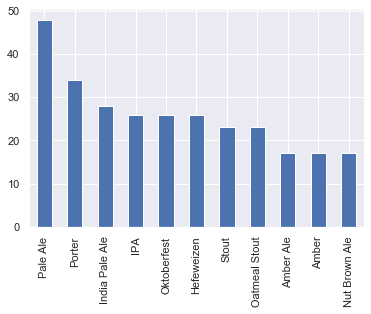

Answer: 
  The top ten names are: 

Pale Ale          48
Porter            34
India Pale Ale    28
Hefeweizen        26
Oktoberfest       26
IPA               26
Stout             23
Oatmeal Stout     23
Nut Brown Ale     17
Amber             17
Name: name, dtype: int64
They are generic and used in maximum 48 times used in this sample (Pale Ale)


In [9]:
#top 10 names
#get occurance of the 10th-often beer name
occurance_10th_value = df_beers["name"].value_counts().sort_values().tail(10).head(1)

#form df with top 10 names and duplicate occurances
df_grouped_names_often = df_beers.groupby("name").filter(lambda x: len(x) > occurance_10th_value-1)

#plot top 10 names and occurances
df_grouped_names_often["name"].value_counts().plot(kind="bar")
plt.show()

print("Answer:" ,"\n"," The top ten names are:", "\n")
print(df_beers["name"].value_counts().sort_values(ascending=False).head(10))
print("They are generic and used in maximum 48 times used in this sample (Pale Ale)")

#Edit: changing the name of the column due to duplicate names with brewery
df_beers["name_beer"] = df_beers["name"]
df_beers.drop("name", axis=1, inplace=True)

### 2. Brewery_id

In [10]:
#explore brewery_id
print(df_beers["brewery_id"].head())
print(df_beers["brewery_id"].describe())

0      812
5     1385
7     1099
9      545
12     545
Name: brewery_id, dtype: object
count     4361
unique    1367
top       1072
freq        38
Name: brewery_id, dtype: object


### Observations: Some breweries have a larger variety of beers in this sample. The values are IDs only. We should enhance the dataset with names of the breweries, longitude and latitude to look who, where which beers brew the beers are brewed

***Task: merge with brewery df on brewery_id, change id to name of the brewery, concat longitude and latitude, reorder meaningful***

In [11]:
#make a copy from raw for breweries and geocodes
df_breweries = df_breweries_raw.copy()
df_breweries = df_breweries.reset_index()

#add long and lat from brewery geocodes on brewery_id to brewery table
df_breweries = pd.merge(df_breweries, df_breweries_geocode_raw, how="left", left_on = "id", right_on = "brewery_id")
df_breweries.drop("accuracy", axis=1, inplace = True)
df_breweries["id =]

#merge beer with brewery on brewery_id
df_beers_brewery = pd.merge(df_beers, df_breweries[["id","name", "city", "country", "latitude", "longitude"]] , how="left", left_on="brewery_id" , right_on="id",)
df_beers_brewery["name_brewery"] = df_beers_brewery["name"]
df_beers_brewery.drop(["brewery_id","name"], axis=1, inplace=True)



#reorder columns
new_cols = ['name_beer', 'cat_id', 'style_id', 'abv', 'ibu', 'srm', 'name_brewery', 'city',
       'country', 'latitude', 'longitude']
df_beers_brewery = df_beers_brewery[new_cols]
df_beers_brewery.head(4519).tail(1)


KeyError: "['id'] not in index"

***Questions:  ***  
***1. How many different beers are brewed on average per brewery + distribution?***   
***2. Which are the top 5 most diverse breweries?***  
***3. What is the avg diversity of beers brewed per brewery per country?***  
***4. In which top 10 countries are the breweries most diverse?***

In [12]:
#1 Group by brewery
df_grouped_brewery = df_beers_brewery.groupby("name_brewery" )
avg_beer_per_brewery = df_grouped_brewery["name_beer"].count().mean()
df_grouped_brewery["name_beer"].count().plot(kind="kde", xlim=(0, 30))
df_grouped_brewery["name_beer"].count().plot(kind="hist", density = True, bins=30)
plt.xticks(np.arange(30))
plt.show()


print("Answer 1: On average(mean) {:.2f} beers are brewed per brewery".format(avg_beer_per_brewery), "\n")

#2 used grouped_object
print("Answer 2: The top 5 most diverse breweries are:")
print(df_grouped_brewery["name_beer"].count().nlargest(5), "\n")

#3 calculate beers/country div by breweries/country
avg_div_per_country = df_beers_brewery.groupby("country")["name_beer"].nunique() / df_beers_brewery.groupby("country")["name_brewery"].nunique()
print("Answer 3: The average diversity in brewed beers per brewerie per country is:" ,"\n",avg_div_per_country.sort_values(ascending = False), "\n")
#4 get largest 10 and make comment on how many breweries are in a country
print("Answer 4: The top ten brewery-diversity countries are:","\n",avg_div_per_country.nlargest(10), "\n")
print("Comment on 4:")
for country in avg_div_per_country.nlargest(10).reset_index()["country"]:
    print(country + " has {} brewery(s)".format(df_beers_brewery.groupby("country").get_group(country)["name_brewery"].nunique()))

NameError: name 'df_beers_brewery' is not defined

### 3. Cat_id

In [13]:
#Make a copy of beers with brewery for further usage (savepoint)
df_bb = df_beers_brewery.copy()

#Explore
print(df_bb["cat_id"].head())
print(df_bb["cat_id"].describe())
print(df_bb["cat_id"].value_counts())
print(df_bb["cat_id"].dtype)

NameError: name 'df_beers_brewery' is not defined

### Results:
* Its a categorical variable
* Too many unique values for categories in categories_raw
* should be replaced by values from df_categories_raw

### Tasks:
0. Clean up the column  
1. Replace IDs with values from df_categories_raw  
2. Change dtype to category

In [14]:
#drop the strange one and change dtype to int64 for merging
print(df_bb[df_bb["cat_id"]==" Weyermann Melonodon"])
df_bb.drop(df_bb[df_bb["cat_id"]==" Weyermann Melonodon"].index, axis=0, inplace=True)
df_bb["cat_id"] = df_bb["cat_id"].astype("float64")

#print value counts to ensure correct dropping
print(df_bb["cat_id"].value_counts())


#Merge with categories_raw
df_bb_cat = pd.merge(df_bb, df_categories_raw[["cat_name"]], how="inner", left_on= "cat_id", right_on="id")

#drop cat_id
df_bb_cat.drop("cat_id", axis=1, inplace = True)

#print head to see if everything is fine
print(df_bb_cat.head())
print(df_bb_cat["cat_name"].describe())

NameError: name 'df_bb' is not defined

***Questions:***  
***1. How are the categories distributed Germany?***  
***2. How is the distribution of North American Ale?***


In [15]:
#Pivoting the table to show it
piv_count_cat_p_country = pd.pivot_table(df_bb_cat, values="name_beer",index="country", columns="cat_name",aggfunc="count")
piv_count_cat_p_country = piv_count_cat_p_country.fillna(0)
fig=plt.figure()

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
piv_count_cat_p_country.loc["Germany",:].plot(kind="bar", ax=ax1)
piv_count_cat_p_country[piv_count_cat_p_country["North American Ale"]<50]["North American Ale"].plot(kind="hist", bins=20, ax=ax2)
ax2.xaxis.set_label_text("Count of North American " + "\n" + "Ale Beer per country")
plt.show()

NameError: name 'df_bb_cat' is not defined

### 4. style_id

In [16]:
# create a savepoint
df_bbc = df_bb_cat.copy()

si = df_bbc["style_id"].astype("float64")

#explore 
print(si.head())
print(si.describe())
print(si.value_counts().sort_values(ascending=False))
print(si.dtype)
print(si.max())
print(si.min())
print(len(si.unique()))
print(si.isna().sum())

NameError: name 'df_bb_cat' is not defined

### Results:  
* categorical variable
* should be replaced with style names from df_styles_raw

### Tasks:
1. Convert to int64
2. Replace with style names from df_styles_raw
3. clean up if necessary


In [17]:
#convert style_id to int
df_bbc["style_id"] = df_bbc["style_id"].astype("float64")
#merge dfs
df_bbcs = pd.merge(df_bbc, df_styles_raw["style_name"], how="inner", left_on="style_id", right_on="id")

#drop style_id columns
df_bbcs.drop("style_id", axis=1, inplace = True)


NameError: name 'df_bbc' is not defined

In [18]:
#explore again
print(df_bbcs["style_name"].describe(),
df_bbcs["style_name"].value_counts(),
df_bbcs["style_name"].unique())

NameError: name 'df_bbcs' is not defined

***Questions:***  
*1. What is the most used style?*  
*2. Which brewery has the most styles in use and what style does she serve?*  
*3. In which country are the most styles in use?*

In [19]:
#1. Group by style, count and use nlargest to find -> Better: use value_count() on style_name column and get the first one
#2. group by brewery, get style columns and use nunique + nlargest to find
#3. Same as 2 but with country instead of brewery

#1. 
most_used_style = df_bbcs.groupby("style_name")["name_beer"].count().nlargest().index[0]
print("1. The most brewed beer style is: " + most_used_style, "\n")

#2.
most_style_div_brewery = df_bbcs.groupby("name_brewery")["style_name", "name_beer"].nunique()
most_style_div_brewery["avg_beers*style"] = most_style_div_brewery["name_beer"]*most_style_div_brewery["style_name"]
style_brewery_name, style_brewery_n = most_style_div_brewery["style_name"].sort_values().index[-1], most_style_div_brewery["style_name"].sort_values().tail(1).values[0]
style_brewery_spb_name, style_brewery_spb_n = most_style_div_brewery["avg_beers*style"].sort_values().index[-1], \
                                                most_style_div_brewery["avg_beers*style"].sort_values().tail(1).values[0]

print("2a. The most diverse brewery in style total is: {} with {} styles in place".format(style_brewery_name, style_brewery_n))
print("2b. The most diverse brewery in styles per beer is {} with {} styles({}) * beers({})".format(style_brewery_spb_name, \
                                                                                                    style_brewery_spb_n, \
                                                                                                    most_style_div_brewery.loc[style_brewery_spb_name][ "style_name"], \
                                                                                                    most_style_div_brewery.loc[style_brewery_spb_name][ "name_beer"]) , "\n")
#3.
most_style_country_name, most_style_country_n  = df_bbcs.groupby("country")["style_name"].nunique().nlargest().index[0], df_bbcs.groupby("country")["style_name"].nunique().nlargest().values[0]
style_country_grouped = df_bbcs.groupby("country")["style_name", "name_brewery"].nunique()
style_country_grouped["styles_per_brewery"] = style_country_grouped["style_name"] / style_country_grouped["name_brewery"]
style_country_mspb_name, style_country_mspb_n = style_country_grouped["styles_per_brewery"].nlargest().index[0],style_country_grouped["styles_per_brewery"].nlargest().values[0] 

print("3a. The most diverse country in style is {} with {} styles brewed in its breweries".format(most_style_country_name, most_style_country_n))
print("3b. The most diverse country in styles per brewery is {} with {} styles per brewery".format(style_country_mspb_name, style_country_mspb_n))

NameError: name 'df_bbcs' is not defined

### 5. abv
This column describe the alcohol per volumne and is a numeric column

In [20]:
#create a savepoint
df_bb = df_bbcs.copy()


NameError: name 'df_bbcs' is not defined

In [21]:
#simplify handling
abv = df_bb["abv"]

#explore
print(abv.describe(), "\n")
print(abv)
#change dtype to float64
abv = abv.astype("float64")

#explore again
print("general description: ","\n", abv.describe(), "\n")
print("# of NaNs: {}".format(abv.isna().sum()), "\n")
print("Outliers: {}".format(abv.quantile([0.01, .99])), "\n")


#summarize in plot to show distribution (without filter)
fig, (ax1, ax2)= plt.subplots(2, 1)
abv.plot(kind="hist", density = True, ax = ax1)
sns.distplot(abv, ax=ax2, rug= True)
plt.show()

#it seem that there are two major groups: with and without alcohol
#now plotting dist without alcohol-free beers
fig2, ax3 = plt.subplots(1,1)
sns.distplot(abv[(abv>0)], ax=ax3, rug= True)
plt.show()

#as a boxplot to identify outliers
plt.subplot()
sns.boxplot(x=abv)
plt.show()



NameError: name 'df_bb' is not defined

### Results:
* column must be converted into float
* column contains no NaNs
* column could be used to distiguish between alcohol-containing and alcohol-free beer
* 2 extreme outliers are identified

### Tasks:
1. Take a look at the outliers and maybe correct the values
2. convert column with corrected values to float64

In [22]:
#taking a closer look on the 2 major outliers (roughly 100% = pure alcohol -> no beer, > 30% -> could be a very special beer)
abv_out = abv[abv>30]
print(abv_out.describe())
print(df_bb.iloc[abv_out.index, :])



NameError: name 'abv' is not defined

In [23]:
print(df_bb[df_bb["city"].str.find("Mnchen")>-1])


NameError: name 'df_bb' is not defined